In [1]:
from spine.spine_exam import SpineStudy
from spine.read import read_study
from spine.visualisation.interactive import interactive_visualization, simple_interactive
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
%matplotlib widget

In [3]:
dataset_path = Path("/Users/mkurtys/datasets/spine/")
root = str(dataset_path/'train_images')
print(dataset_path.exists())

True


In [4]:
descriptions = pd.read_csv(dataset_path/"train_series_descriptions.csv")
coordinates = pd.read_csv(dataset_path/"train_label_coordinates.csv")
submissions = pd.read_csv(dataset_path/"sample_submission.csv")
train = pd.read_csv(dataset_path/"train.csv")

In [5]:
train_melt = train.melt(id_vars="study_id").sort_values(["study_id", "variable"]).rename(columns={"variable": "condition_level"})
coordinates["instance_number"] = coordinates["instance_number"].astype(int)
coordinates["instance_number"] = coordinates["instance_number"] - 1
coordinates["condition_level"] = coordinates.apply(lambda x: x["condition"].lower().replace(" ", "_") + "_" + x["level"].lower().replace("/", "_"), axis=1)
coordinates["condition_unsided"] = coordinates.apply(lambda x: x["condition"].lower().replace(" ", "_").replace("left_", "").replace("right_", "").strip(), axis=1)
coordinates = pd.merge(on=["study_id", "condition_level"], left=coordinates, right=train_melt, how="left")
coordinates = pd.merge(on=["study_id", "series_id"], left=coordinates, right=descriptions, how="left")
coordinates.head()

,study_id,series_id,instance_number,condition,level,x,y,condition_level,condition_unsided,value,series_description
0,4003253,702807833,7,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis,Normal/Mild,Sagittal T2/STIR
1,4003253,702807833,7,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis,Normal/Mild,Sagittal T2/STIR
2,4003253,702807833,7,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis,Normal/Mild,Sagittal T2/STIR
3,4003253,702807833,7,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis,Normal/Mild,Sagittal T2/STIR
4,4003253,702807833,7,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,spinal_canal_stenosis_l5_s1,spinal_canal_stenosis,Normal/Mild,Sagittal T2/STIR


In [6]:
coordinates["condition_unsided"].value_counts()

condition_unsided
neural_foraminal_narrowing    19719
subarticular_stenosis         19220
spinal_canal_stenosis          9753
Name: count, dtype: int64

In [7]:
descriptions.head()


,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1


In [8]:
studies = descriptions["study_id"].unique()

In [9]:
study_id = studies[5]
series_ids = descriptions[descriptions["study_id"] == study_id]["series_id"].values.tolist()
series_descriptions=descriptions[descriptions["study_id"] == study_id]["series_description"].values.tolist()
study_id

11340341

In [10]:
study= read_study(root=root, study_id=study_id,
            series_ids=series_ids,
            series_descriptions=series_descriptions)

In [11]:
[print(series.series_id, series.description) for series in study.series]

1224932122 Axial T2
2231042680 Sagittal T1
3543553307 Sagittal T2/STIR


[None, None, None]

In [12]:
study.series[2].volume.shape

(18, 448, 448)

In [13]:
from spine.transforms import image_to_patient_coords_3d
study_coords = coordinates[coordinates["study_id"] == study_id].copy()

def find_patient_coords(row):
    series = study.get_series(row["series_id"])
    instance = series.get_instance(row["instance_number"])
    patient_coords = image_to_patient_coords_3d(row["x"], row["y"],
                               image_position_patient=instance.position,
                               image_orientation_patient=instance.orientation,
                               pixel_spacing=instance.pixel_spacing)
    return patient_coords

study_coords["patient_coords"] = study_coords.apply(find_patient_coords, axis=1)

In [14]:
study_coords

,study_id,series_id,instance_number,condition,level,x,y,condition_level,condition_unsided,value,series_description,patient_coords
125,11340341,1224932122,4,Left Subarticular Stenosis,L1/L2,183.253769,166.700168,left_subarticular_stenosis_l1_l2,subarticular_stenosis,Normal/Mild,Axial T2,"[18.227357836731883, 81.5328069984707, -429.50..."
126,11340341,1224932122,5,Right Subarticular Stenosis,L1/L2,148.824909,166.746516,right_subarticular_stenosis_l1_l2,subarticular_stenosis,Normal/Mild,Axial T2,"[1.0279480455747307, 80.60632879143897, -432.9..."
127,11340341,1224932122,14,Left Subarticular Stenosis,L2/L3,184.861809,161.340034,left_subarticular_stenosis_l2_l3,subarticular_stenosis,Normal/Mild,Axial T2,"[19.195739252512286, 72.78768777187524, -463.4..."
128,11340341,1224932122,14,Right Subarticular Stenosis,L2/L3,151.612366,161.729094,right_subarticular_stenosis_l2_l3,subarticular_stenosis,Normal/Mild,Axial T2,"[2.570516388639417, 72.64255639116973, -463.44..."
129,11340341,1224932122,23,Left Subarticular Stenosis,L3/L4,183.253769,157.051926,left_subarticular_stenosis_l3_l4,subarticular_stenosis,Moderate,Axial T2,"[18.511923817146272, 68.32635951070714, -495.4..."
130,11340341,1224932122,23,Right Subarticular Stenosis,L3/L4,153.284840,156.711672,right_subarticular_stenosis_l3_l4,subarticular_stenosis,Moderate,Axial T2,"[3.5387107882356403, 67.87705499673588, -495.0..."
131,11340341,1224932122,32,Left Subarticular Stenosis,L4/L5,181.645729,150.083752,left_subarticular_stenosis_l4_l5,subarticular_stenosis,Moderate,Axial T2,"[18.04258066353237, 66.53625090967098, -527.35..."
132,11340341,1224932122,32,Right Subarticular Stenosis,L4/L5,147.152436,152.809233,right_subarticular_stenosis_l4_l5,subarticular_stenosis,Moderate,Axial T2,"[0.7720403833346476, 67.53732806998457, -527.1..."
133,11340341,1224932122,41,Left Subarticular Stenosis,L5/S1,181.645729,140.971524,left_subarticular_stenosis_l5_s1,subarticular_stenosis,Normal/Mild,Axial T2,"[18.314585268488088, 69.76242270100587, -557.0..."
134,11340341,1224932122,41,Right Subarticular Stenosis,L5/S1,146.037453,141.101916,right_subarticular_stenosis_l5_s1,subarticular_stenosis,Normal/Mild,Axial T2,"[0.5133318944306633, 69.53541428315182, -557.2..."


interactive(children=(IntSlider(value=0, description='axial_slice', max=44), IntSlider(value=0, description='s…

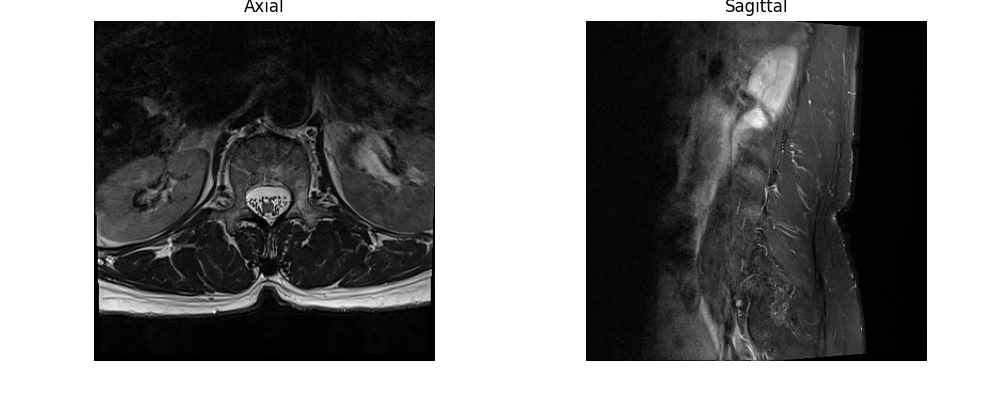

In [15]:
interactive_plot = simple_interactive(study.series[0], study.series[2],
                                      study_coords)
display(interactive_plot)
# display(fig)

In [16]:
import numpy as np

In [17]:
type(np.clip(10.0, 0, 20))

numpy.float64